# Analiza vulgarnosti u Tarantinovim filmovima

Alati: Jupyter Notebook, Python (pandas, matplotlib i sl.), SQLite

In [1]:
import pandas as pd
df = pd.read_csv('profanity.csv')
df

,movie,type,word,minutes_in
0,Reservoir Dogs,word,dick,0.40
1,Reservoir Dogs,word,dicks,0.43
2,Reservoir Dogs,word,fucked,0.55
3,Reservoir Dogs,word,fucking,0.61
4,Reservoir Dogs,word,bullshit,0.61
...,...,...,...,...
1889,Jackie Brown,word,motherfucker,141.93
1890,Jackie Brown,word,ass,142.43
1891,Jackie Brown,word,fucking,142.47
1892,Jackie Brown,word,goddamn,142.97


In [24]:
data = {}
with open('profanity.csv') as file:
    for f in list(enumerate(file.readlines()[1:])):
        data[f[0]] = f[1:][0].rstrip().split(',')

In [3]:
filmovi = set(df.movie)

In [4]:
film = [('Django Unchained', 84, 2012), 
 ('Pulp Fiction', 89, 1994), 
 ('Inglorious Basterds', 83, 2009), 
 ('Kill Bill: Vol. 1', 81, 2003), 
 ('Jackie Brown', 75, 1997), 
 ('Reservoir Dogs', 83, 1992), 
 ('Kill Bill: Vol. 2', 80, 2004)]

In [5]:
tip_vulgarnosti = set(df.type)

In [6]:
rijec = set(df.word)
rijec.add('death')

In [7]:
vulg = {}.fromkeys(rijec, [])
for entry in data:
    time = [[ entry, data[entry][3] ]]
    if data[entry][1] == 'word':
        vulg[data[entry][2]] = vulg[data[entry][2]] + time
    elif data[entry][1] == 'death':
        vulg['death'] = vulg['death'] + time

In [8]:
sorted_vulgs = []
only_sorted = []
base_words = ['shit', 'fuck', 'ass', 'damn', 'dick', 'cock', 'bitch', 'cunt', ]
for word in vulg.keys():
    for base in base_words:
        if type(word) == type('') and base in word:
            sorted_vulgs.append((base, word))
            only_sorted.append(word)

In [25]:
sorted_vulgs_db = sorted_vulgs + [(r,r) for r in rijec if r not in only_sorted]
sorted_vulgs_db[:5]

[('shit', 'shittiest'),
 ('dick', 'dick'),
 ('ass', 'assholes'),
 ('dick', 'dickless'),
 ('fuck', 'fuckup')]

In [10]:
korijen = base_words + [r for r in rijec if r not in only_sorted]

In [11]:
korijen_db = []
for item in korijen:
    korijen_db.append((item,))

In [12]:
kategorije = ['fekalije', 'seks', 'psovke', 'pogrdnost', 'nacija', 'rasa', 'smrt']
kategorije_db = []
for item in kategorije:
    kategorije_db.append((item,))

## Upravljanje bazom podataka

In [13]:
import sqlite3

In [14]:
conn = sqlite3.connect('baza.db')
c = conn.cursor()



### Tablica korijen
```sqlite
CREATE TABLE korijen(
    korijen_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT
);
```

```sqlite
INSERT INTO korijen(naziv) VALUES (?);
```

In [15]:
drop_table_korijen = '''
DROP TABLE korijen;
'''
c.execute(drop_table_korijen)

create_table_korijen='''
CREATE TABLE korijen(
    korijen_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT
);
'''

c.execute(create_table_korijen)

insert_into_korijen = '''
INSERT INTO korijen(naziv) VALUES (?);
'''
c.executemany(insert_into_korijen, korijen_db)
conn.commit()

## Tablica kategorija

```sqlite
CREATE TABLE kategorija(
    kategorija_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT
);
```

```sqlite
INSERT INTO kategorija(naziv) VALUES (?);
```


In [16]:
drop_table_kat = '''
DROP TABLE kategorija;
'''
c.execute(drop_table_kat)

create_table_kat = '''
CREATE TABLE kategorija(
    kategorija_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT
);'''

c.execute(create_table_kat)
insert_into_kat = '''
INSERT INTO kategorija(naziv) VALUES (?);
'''
c.executemany(insert_into_kat, kategorije_db)
conn.commit()

### Tablica film
```sqlite
CREATE TABLE film(
    film_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT NOT NULL,
    godina INTEGER,
    ocjena INTEGER, --- 0 <= ocjena <= 100
    CHECK (ocjena <= 100 AND
           ocjena >= 0)
);
```
```sqlite
INSERT INTO film (naziv, ocjena, godina) VALUES (?, ?, ?);
```

In [17]:
drop_table_film = '''DROP TABLE film;'''
c.execute(drop_table_film)

create_table_film = '''
CREATE TABLE film(
    film_id INTEGER PRIMARY KEY AUTOINCREMENT,
    naziv TEXT NOT NULL,
    godina INTEGER,
    ocjena INTEGER
    CHECK (ocjena <= 100 AND
           ocjena >= 0)
);
'''
c.execute(create_table_film)

insert_into_film = '''
INSERT INTO film (naziv, ocjena, godina) VALUES (?, ?, ?);
'''
c.executemany(insert_into_film, film)
conn.commit()

### Tablica rijec

```sqlite
CREATE TABLE rijec (
    rijec_id INTEGER PRIMARY KEY, ---non-autoincrement!
    rijec TEXT NOT NULL,
    vrijeme REAL NOT NULL,
    film_fk INTEGER,
    FOREIGN KEY (film_dk) ---TODO
        REFERENCES film (film_id) 
    korijen_fk INTEGER,
    FOREIGN KEY (korijen_fk) ---TODO
        REFENCES korijen (korijen_id)
    kategorija_fk INTEGER
    FOREIGN KEY (kategorija_fk) ---TODO
        REFERENCES kategorija (kategorija_id)
);```


```sqlite
INSERT INTO rijec VALUES (?,?,?,NULL,NULL,NULL)

```

In [18]:
drop_table_rijec ='''
DROP TABLE rijec;
'''
c.execute(drop_table_rijec)

create_table_rijec = '''
CREATE TABLE rijec (
    rijec_id INTEGER PRIMARY KEY,
    rijec TEXT NOT NULL,
    vrijeme REAL NOT NULL,
    film_fk INTEGER,
    korijen_fk INTEGER,
    kategorija_fk INTEGER
);
'''
c.execute(create_table_rijec)

insert_into_rijec = '''
INSERT INTO rijec VALUES (?,?,?,NULL,NULL,NULL)
'''
c.executemany(insert_into_rijec, [(a, data[a][2], data[a][3]) for a in data])
conn.commit()

```sqlite
UPDATE rijec SET korijen_fk = (
    SELECT korijen_id FROM korijen
    WHERE naziv = ?
) WHERE rijec = ?
```

In [19]:
update_korijen_fk = '''
UPDATE rijec SET korijen_fk = (
    SELECT korijen_id FROM korijen
    WHERE naziv = ?
) WHERE rijec = ?
'''
c.executemany(update_korijen_fk, sorted_vulgs_db)
conn.commit()

```sqlite
UPDATE rijec SET film_fk = (
    SELECT film_id FROM film
    WHERE naziv = ?
) WHERE rijec_id = ?
```

In [20]:
update_film_fk = '''
UPDATE rijec SET film_fk = (
    SELECT film_id FROM film
    WHERE naziv = ?
) WHERE rijec_id = ?
'''
film_id = [(data[a][0], a) for a in data]
c.executemany(update_film_fk, film_id)
conn.commit()

### Pregled tablica

In [21]:
tablice = ['rijec', 'kategorija', 'korijen', 'film']

for tablica in tablice:
    select_upit = 'SELECT * FROM ' + tablica
    rez = c.execute(select_upit)
    print('===== ' + tablica + ' =====')
    for a in rez.fetchmany(10):
        print(a)

===== rijec =====
(0, 'dick', 0.4, 6, 5, None)
(1, 'dicks', 0.43, 6, 5, None)
(2, 'fucked', 0.55, 6, 2, None)
(3, 'fucking', 0.61, 6, 2, None)
(4, 'bullshit', 0.61, 6, 1, None)
(5, 'fuck', 0.66, 6, 2, None)
(6, 'shit', 0.9, 6, 1, None)
(7, 'fuck', 1.43, 6, 2, None)
(8, 'dicks', 1.56, 6, 5, None)
(9, 'fuck', 1.66, 6, 2, None)
===== kategorija =====
(1, 'fekalije')
(2, 'seks')
(3, 'psovke')
(4, 'pogrdnost')
(5, 'nacija')
(6, 'rasa')
(7, 'smrt')
===== korijen =====
(1, 'shit')
(2, 'fuck')
(3, 'ass')
(4, 'damn')
(5, 'dick')
(6, 'cock')
(7, 'bitch')
(8, 'cunt')
(9, None)
(10, 'hell')
===== film =====
(1, 'Django Unchained', 2012, 84)
(2, 'Pulp Fiction', 1994, 89)
(3, 'Inglorious Basterds', 2009, 83)
(4, 'Kill Bill: Vol. 1', 2003, 81)
(5, 'Jackie Brown', 1997, 75)
(6, 'Reservoir Dogs', 1992, 83)
(7, 'Kill Bill: Vol. 2', 2004, 80)


### Upiti

Ispitivanje postoji li vezanost između količine psovki i ocjene.

In [40]:
count_per_film = '''
SELECT COUNT(), film.ocjena FROM rijec, film
WHERE film_id = film_fk
GROUP BY film_fk; 
'''
rez = c.execute(count_per_film).fetchall()
print(rez)

[(309, 84), (476, 89), (106, 83), (120, 81), (372, 75), (431, 83), (80, 80)]


In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [57]:
podatci = sorted(rez)
(list(zip(*rez)))

[(80, 80), (106, 83), (120, 81), (309, 84), (372, 75), (431, 83), (476, 89)]


[(309, 476, 106, 120, 372, 431, 80), (84, 89, 83, 81, 75, 83, 80)]

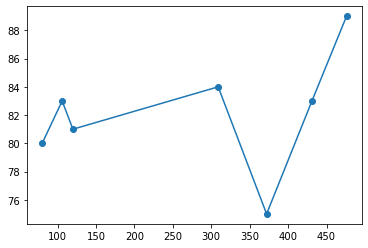

In [60]:
plt.scatter(*zip(*podatci))
plt.plot(*zip(*podatci))
plt.show()